## Assignment 10

In [1]:
!git clone https://github.com/scarecrow-tsai/eva6-assignment-10
%cd eva6-assignment-10/

!pip install -U albumentations

Cloning into 'eva6-assignment-10'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 113 (delta 43), reused 97 (delta 27), pack-reused 0
Receiving objects: 100% (113/113), 5.13 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/eva6-assignment-10
     |████████████████████████████████| 98 kB 5.6 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-07-30 10:11:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  96.5MB/s    in 2.5s    

2021-07-30 10:11:45 (96.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
!unzip -q tiny-imagenet-200.zip

In [4]:
!mv tiny-imagenet-200/ tiny-imagenet/
!ls

anchor-boxes  main.ipynb  README.md	 tiny-imagenet-200.zip
app	      main.py	  tiny-imagenet


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from albumentations.pytorch import ToTensorV2

from app.models.resnet import ResNet
from app.utils.lr_finder import LRFinder
from app.utils.transforms import transforms
from app.explainability.gradcam import GradCAM
from app.utils.misc import set_seed, tensor_to_image
from app.datasets.tinyimagenet import load_tinyimagenet
from app.utils.train_test_loops import train_loop, test_loop
from app.utils.result_stats import loss_acc_curves, score_report
from app.utils.result_analysis import (
    get_misclassified_info,
    visualize_misclassified_images,
    misclassified_gradcam
)

from app.utils.lr_finder import LRFinder

from app.utils.dataset import (
    calc_data_stats,
    visualise_transforms,
    class_to_idx,
    idx_to_class,
)

import matplotlib.pyplot as plt

set_seed(69)

In [14]:
################################
## CONFIG
################################

DATASET_NAME = "tiny-imagenet"
DATASET_PATH = f"./{DATASET_NAME}/"
NUM_CLASSES = 200
NUM_INPUT_CHANNELS = 3

BATCH_SIZE = 256
EPOCHS = 2
LEARNING_RATE = 0.001

# SET GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nWe're using =>", device)


We're using => cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

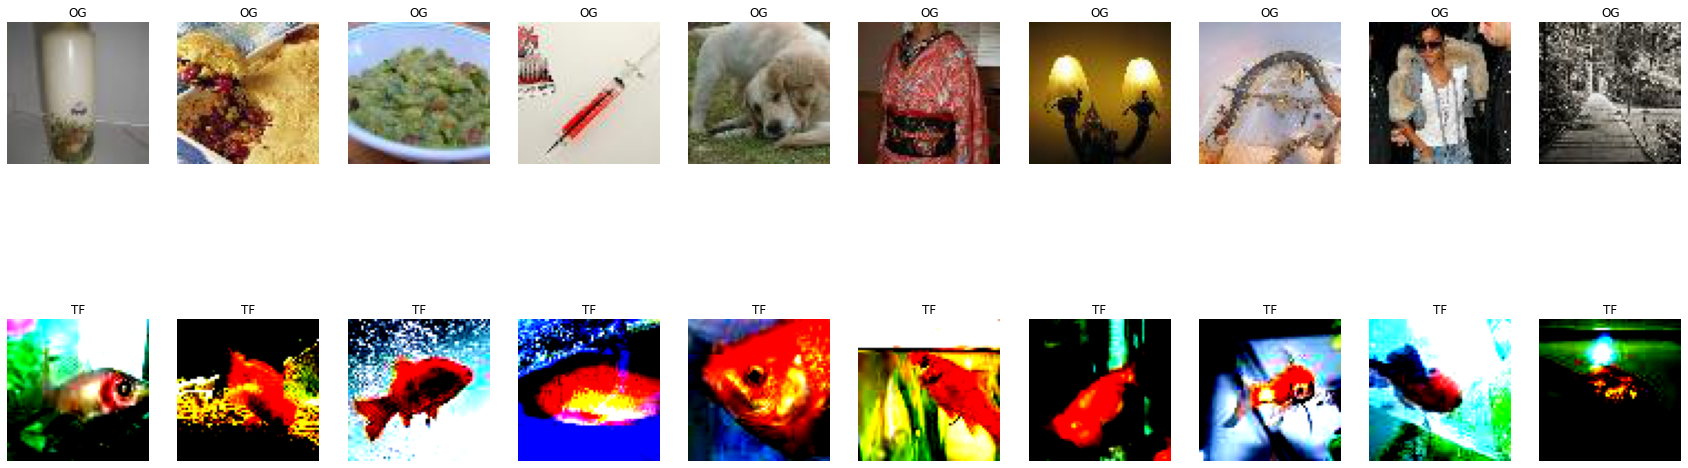

In [15]:
################################
## LOAD DATASET
################################

# datasets
og_dataset = load_tinyimagenet(
    dataset_path=DATASET_PATH, is_train=False, image_transforms=ToTensorV2(),
)

# calculate dataset mean and std
dataset_mean, dataset_std = calc_data_stats(og_dataset)

image_transforms = transforms(dataset_mean, dataset_std)

train_dataset = load_tinyimagenet(
    dataset_path=DATASET_PATH,
    is_train=True,
    image_transforms=image_transforms["train"],
)

test_dataset = load_tinyimagenet(
    dataset_path=DATASET_PATH,
    is_train=False,
    image_transforms=image_transforms["test"],
)


class2idx = class_to_idx(og_dataset.classes)
idx2class = idx_to_class(class2idx)


visualise_transforms(
    original_data=og_dataset, transformed_data=train_dataset, num_samples=10
)

In [16]:
################################
## CREATE DATALOADERS
################################

# dataloader
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

## Data Sanity Check
print(f"\nTrain loader = {next(iter(train_loader))[0].shape}")
print(f"Val loader = {next(iter(val_loader))[0].shape}")
print(f"Test loader = {next(iter(test_loader))[0].shape}")
print(f"\nTrain loader length = {len(train_loader)}")
print(f"Val loader length = {len(val_loader)}")
print(f"Test loader length = {len(test_loader)}")


Train loader = torch.Size([256, 3, 64, 64])
Val loader = torch.Size([256, 3, 64, 64])
Test loader = torch.Size([256, 3, 64, 64])

Train loader length = 391
Val loader length = 391
Test loader length = 40


In [17]:
################################
## LOAD MODEL
################################

model = ResNet(input_channels=NUM_INPUT_CHANNELS, num_classes=NUM_CLASSES, block_cfg=[3, 4, 6, 3])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)

In [18]:
# lr_finder = LRFinder(model=model, criterion=criterion, optimizer=optimizer, device=device)
# LEARNING_RATE = lr_finder.run(dataloader=train_loader)
# lr_finder.plot()

In [19]:
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
#                                           max_lr=round(LEARNING_RATE, 3), 
#                                           steps_per_epoch=len(train_loader), 
#                                           epochs=EPOCHS)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.99)


Begin training.


Epoch 01/2: | Train Loss: 5.38392 | Val Loss: 5.30427 | Train Acc: 0.243% | Val Acc: 0.499%
Epoch 02/2: | Train Loss: 4.91582 | Val Loss: 5.30317 | Train Acc: 0.284% | Val Acc: 0.499%



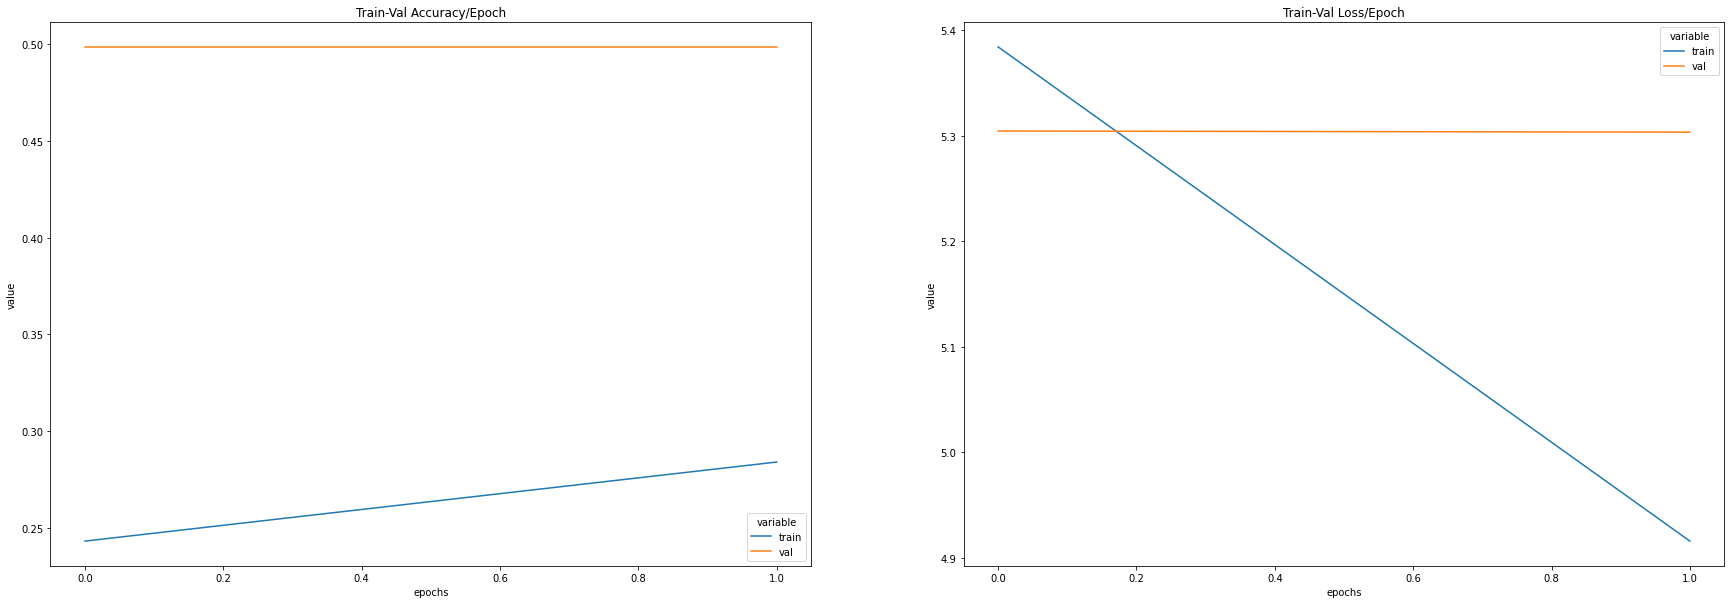

In [20]:
###########################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


loss_acc_curves(loss_stats=loss_stats, acc_stats=acc_stats)

In [21]:
################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)

Test Accuracy = 0.0


Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   10000.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00   10000.0
   macro avg       0.00      0.00      0.00   10000.0
weighted avg       0.00      0.00      0.00   10000.0




Confusion Matrix: 

[[    0 10000]
 [    0     0]]

None


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


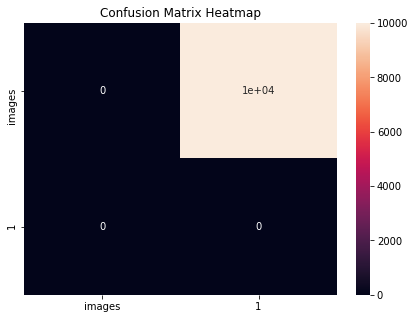

In [22]:
################################
## Result Stats
################################
print(score_report(y_true_list, y_pred_list, idx2class))

KeyError: ignored

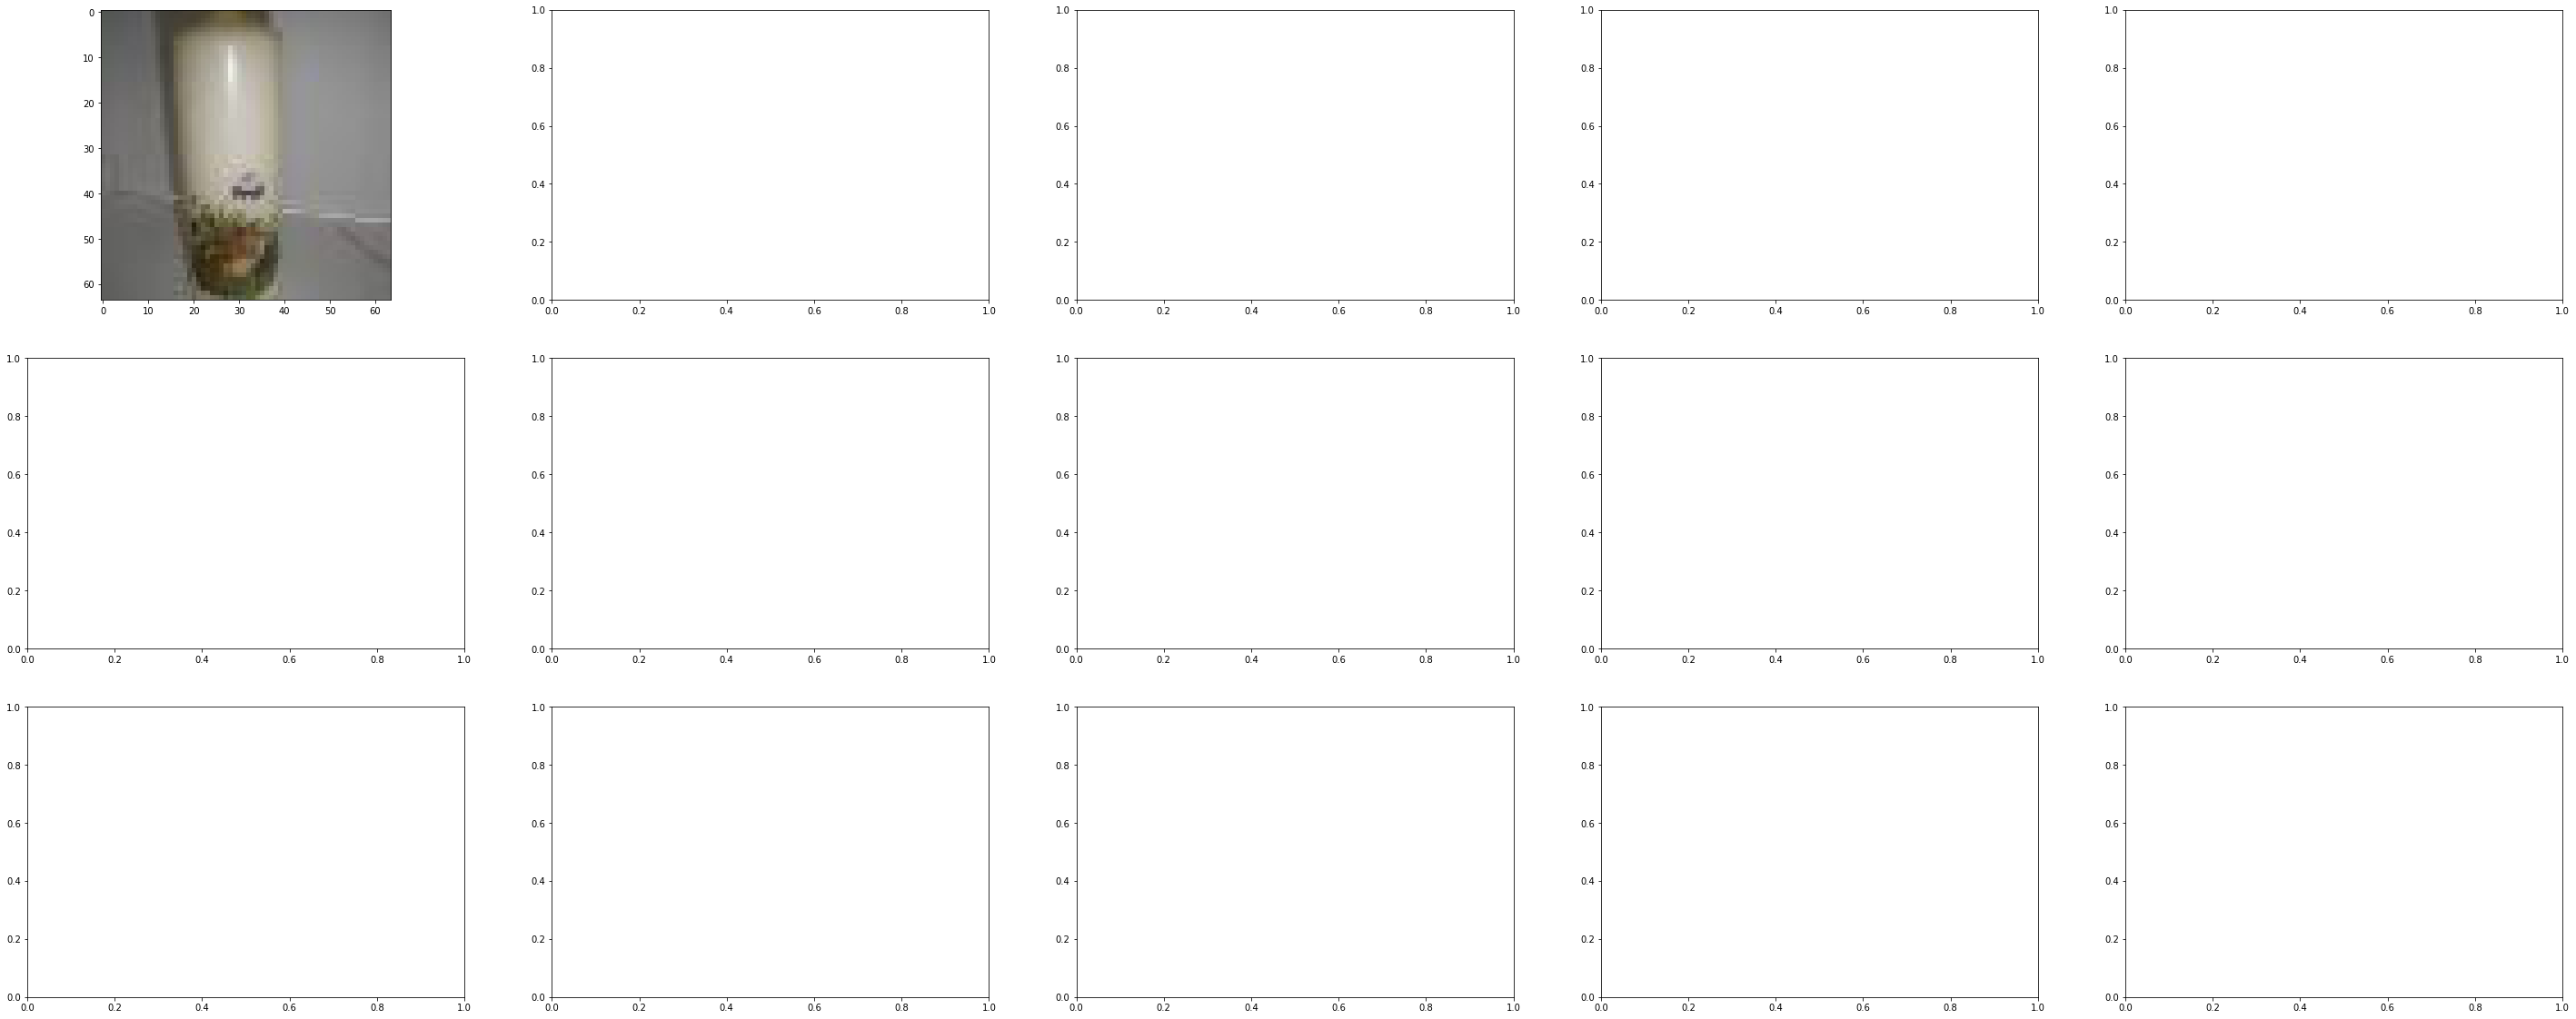

In [23]:
################################
## Result Analysis
################################

def get_misclassified_info(y_pred_list, y_true_list):
    return [
        {"idx": i, "pred": pred, "true": actual}
        for i, (pred, actual) in enumerate(zip(y_pred_list, y_true_list))
        if pred != actual
    ]


misclassified_info = get_misclassified_info(
    y_pred_list=y_pred_list, y_true_list=y_true_list
)


visualize_misclassified_images(
    misclassified_info=misclassified_info,
    dataset=og_dataset,
    idx_to_class=idx2class,
    num_samples=11,
)

In [ ]:
################################
## GradCAM
################################
x_test, y_test = test_dataset[40]


tensor_to_image(x_test)

In [ ]:
cam = GradCAM(
    model=trained_model, target_layer=trained_model.layer_2.base_layer[-1].base_block[-1][0]
)

output = cam(x_test.to(device))


plt.imshow(output)

In [ ]:
misclassified_gradcam(
    model = trained_model,
    misclassified_info=misclassified_info,
    dataset=test_dataset,
    idx_to_class=idx2class,
    num_samples=10,
    device=device
)